# Irregular elements and higher-order approximation

#### Imports

In [407]:
import matplotlib.pyplot as plt;
import numpy as np;
import numpy.linalg as linalg;
import math;

from sympy import *;
from sympy.utilities import *;
from ipywidgets import *;

#### Constants

In [408]:
# Symbol for symbolic expression
x = Symbol('x');

# Lagrange polynomial
def lagrange(p, i):
    width = 1.0/p;
    this = i * width;
    # Numerator
    num = 1;
    for j in range(0, p + 1):
        if(j != i):
            num = Mul(num, x - (j*width));
    # Denominator
    denom = 1;
    for j in range(0, p + 1):
        if(j != i):
            denom = Mul(denom, this - (j*width));
    denom = Pow(denom, -1);
    return Mul(num, denom);

degree = 4;
phi = [];
for i in range(0, degree + 1):
    phi += [lagrange(degree, i)];

# Constant
c = 1;

# Delta time
dt = 0.0001;

# Amount of iterations
iterations = 150000;

# Stepsize
stepSize = 1000;

# Time
t = 0;

#### Elements and nodes

In [409]:
# Elements
elements = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 2.0];
elementCount = len(elements) - 1;

# Extremal nodes
minNode = min(elements);
maxNode = max(elements);

# Generate nodes
nodeCount = 1 + (degree * elementCount);

nodes = [];
for i in range(0, elementCount):
    elementWidth = elements[i + 1] - elements[i];
    partWidth = elementWidth/degree;
    for p in range(0, degree):
        nodes += [elements[i] + (partWidth * p)];
nodes += [maxNode];

#### Matrix construction

In [410]:
# Time coefficient matrix
T = np.zeros((nodeCount, nodeCount));

def integ(phi1, phi2, h):
    product = Mul(phi1, phi2);
    return h*integrate(product, (x, 0, 1));

for i in range(0, elementCount):
    elementWidth = elements[i + 1] - elements[i];
    for n in range(0, degree + 1):
        for m in range(0, degree + 1):
            T[(degree * i) + n, (degree * i) + m] += integ(phi[n], phi[m], elementWidth);

for i in range(0,nodeCount):
    T[0,i]           = 0;
    T[nodeCount-1,i] = 0;
T[0,0] = 1;
T[nodeCount-1,nodeCount-1] = 1;

#Time coefficient matrix

S = np.zeros((nodeCount, nodeCount));

def diffInteg(phi1, phi2, h, trans, invtrans):
    # Transform local to global
    gPhi1 = phi1.subs(x, invtrans);
    gPhi2 = phi2.subs(x, invtrans);
    # Take global derivative
    derGPhi1 = (diff(gPhi1, x));
    derGPhi2 = (diff(gPhi2, x));
    # Transform global to local
    derPhi1 = derGPhi1.subs(x, trans);
    derPhi2 = derGPhi2.subs(x, trans);
    product = Mul(derPhi1, derPhi2);
    return h*integrate(product, (x,0,1));

for i in range(0, elementCount):
    elementWidth = elements[i + 1] - elements[i];
    transform = (elementWidth * x) + (elements[i]);
    inversetransform = (x - elements[i])/elementWidth;
    for n in range(0, degree + 1):
        for m in range(0, degree + 1):
            S[(degree * i) + n, (degree * i) + m] += diffInteg(phi[n], phi[m], elementWidth, transform, inversetransform);

for i in range(0,nodeCount):
    S[0,i]           = 0;
    S[nodeCount-1,i] = 0;

#### Iteration and evaluation

In [411]:
# A single time step
def iteration(v, vDer):
    vNew = v + dt*vDer;
    q = -c*c*S@v;
    r = linalg.solve(T, q);
    vDerNew = vDer + dt*r;
    return (vNew, vDerNew);

# Evaluation
def ev(u, pos):
    # Find element the pos(ition) is in
    for i in range(0, elementCount):
        if(elements[i] <= pos <= elements[i+1]):
            elementWidth = elements[i + 1] - elements[i];
            transformedPos = (pos - elements[i])/elementWidth;
            # Calculate linear sum
            sum = 0;
            for p in range(0, degree+1):
                sum += u[(i*degree) + p]*phi[p].subs(x, transformedPos);
            return sum;
    return 0;

#### Initial value

In [412]:
# The real solution
def realU(x, t):
    return np.cos(2*np.pi*t)*np.sin(2*np.pi*x) + np.cos(4*np.pi*t)*np.sin(4*np.pi*x) ;

# Set initial value
u    = np.zeros((nodeCount, 1));
uDer = np.zeros((nodeCount, 1));

k = 2*math.pi;

for i in range(0, nodeCount):
    coord   = nodes[i];
    u[i]    = realU(coord, 0);
    uDer[i] = 0;

#### Interactive Simulation

In [413]:
data = [];
data.append(u);
bigspacing = np.linspace(0.0, 2.0, 100);

uNew    = np.zeros((nodeCount, 1));
uDerNew = np.zeros((nodeCount, 1));

for i in range(0, iterations):
    uNew, uDerNew = iteration(u,uDer);
    u = uNew;
    uDer = uDerNew;
    data.append(u);
    t += dt;

def animation(t):
    plt.rcParams["figure.figsize"] = (6,4);
    axes = plt.gca();
    axes.set_ylim([-1.5,1.5]);
    axes.set_xlim([0,2]);
    plt.title("t = " + str(t*dt));
    plt.ylabel("u(x,t)");
    plt.xlabel("x");
    evaluation = np.linspace(0.0, 2.0, 100);
    for i in range(0, 100):
        evaluation[i] = ev(data[t], evaluation[i]);
    plt.plot(bigspacing, realU(bigspacing, t*dt), "r--");
    plt.plot(bigspacing, evaluation, "b-");
    plt.plot(nodes, data[t], "bo");
    plt.plot(elements, np.zeros((len(elements),1)), "go");
    plt.plot([0,2],[0,0], "g-", linewidth=0.5);

interact(animation, t = widgets.IntSlider(min = 0, max = iterations, step = stepSize, value = 0));

interactive(children=(IntSlider(value=0, description='t', max=150000, step=1000), Output()), _dom_classes=('widget-interact',))

#### Static plots

[0, 6666, 16666, 30000, 102500]


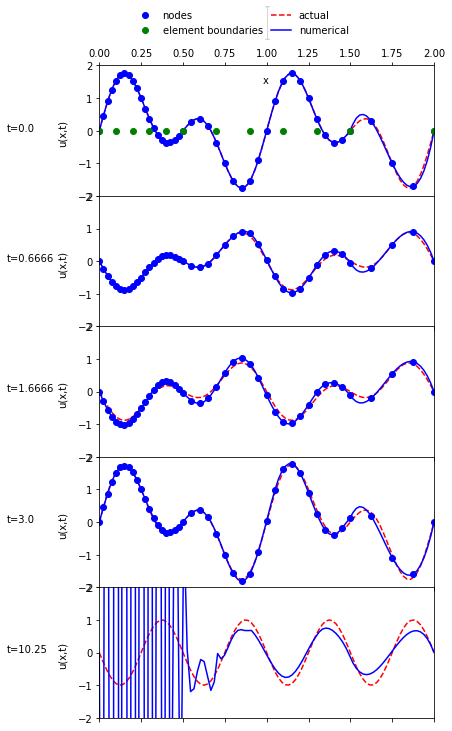

In [414]:
plt.rcParams["figure.figsize"] = (6,12)

timespace = [0, (int)(2.0/(3.0*dt)), (int)(5.0/(3.0*dt)), (int)(3.0/dt), (int)(10.25/dt)];

print(timespace);

maxY = 2;
minY = -2;

plt.subplots_adjust(hspace=.0);

ax1 = plt.subplot("511");
ax1.set_ylim([minY, maxY]);
ax1.set_xlim([0,2]);
plt.plot(bigspacing, realU(bigspacing, timespace[0]*dt), "r--", label='actual');
evaluation = np.linspace(0.0, 2.0, 100);
for i in range(0, 100):
    evaluation[i] = ev(data[timespace[0]], evaluation[i]);
plt.plot(bigspacing, evaluation, "b-", label="numerical");
plt.plot(nodes, data[timespace[0]], "bo", label="nodes");
plt.plot(elements, np.zeros(len(elements)), "go", label="element boundaries");
plt.text(-0.55,0,"t="+str(dt*timespace[0]));
plt.text(-0.25,0.1,"u(x,t)", rotation=90);
plt.text(0.975, 1.45, "x");
plt.legend(bbox_to_anchor=(0.5, 1.2, 0., 0.1), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
ax1.xaxis.tick_top();

ax2 = plt.subplot("512", sharex=ax1);
ax2.set_ylim([minY, maxY]);
ax2.set_xlim([0,2]);
plt.plot(bigspacing, realU(bigspacing, timespace[1]*dt), "r--");
evaluation = np.linspace(0.0, 2.0, 100);
for i in range(0, 100):
    evaluation[i] = ev(data[timespace[1]], evaluation[i]);
plt.plot(bigspacing, evaluati on, "b-", label="numerical");
plt.plot(nodes, data[timespace[1]], "bo");
plt.text(-0.55,0,"t=0.6666");#+str(dt*timespace[1]));
plt.text(-0.25,0.1,"u(x,t)", rotation=90);
plt.setp(ax2.get_xticklabels(), visible=False);

ax3 = plt.subplot("513", sharex=ax1);
ax3.set_ylim([minY, maxY]);
ax3.set_xlim([0,2]);
plt.plot(bigspacing, realU(bigspacing, timespace[2]*dt), "r--");
evaluation = np.linspace(0.0, 2.0, 100);
for i in range(0, 100):
    evaluation[i] = ev(data[timespace[2]], evaluation[i]);
plt.plot(bigspacing, evaluation, "b-", label="numerical");
plt.plot(nodes, data[timespace[2]], "bo");
plt.text(-0.55,0,"t="+str(dt*timespace[2]));
plt.text(-0.25,0.1,"u(x,t)", rotation=90);
plt.setp(ax3.get_xticklabels(), visible=False);

ax4 = plt.subplot("514", sharex=ax1);
ax4.set_ylim([minY, maxY]);
ax4.set_xlim([0,2]);
plt.plot(bigspacing, realU(bigspacing, timespace[3]*dt), "r--");
evaluation = np.linspace(0.0, 2.0, 100);
for i in range(0, 100):
    evaluation[i] = ev(data[timespace[3]], evaluation[i]);
plt.plot(bigspacing, evaluation, "b-", label="numerical");
plt.plot(nodes, data[timespace[3]], "bo");
plt.text(-0.55,0,"t="+str(dt*timespace[3]));
plt.text(-0.25,0.1,"u(x,t)", rotation=90);
plt.setp(ax4.get_xticklabels(), visible=False);

ax5 = plt.subplot("515", sharex=ax1);
ax5.set_ylim([minY, maxY]);
ax5.set_xlim([0,2]);
plt.plot(bigspacing, realU(bigspacing, timespace[4]*dt), "r--");
evaluation = np.linspace(0.0, 2.0, 100);
for i in range(0, 100):
    evaluation[i] = ev(data[timespace[4]], evaluation[i]);
plt.plot(bigspacing, evaluation, "b-", label="numerical");
plt.text(-0.55,0,"t="+str(dt*timespace[4]));
plt.text(-0.25,0.1,"u(x,t)", rotation=90);
plt.setp(ax5.get_xticklabels(), visible=False);